In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import seaborn as sns

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

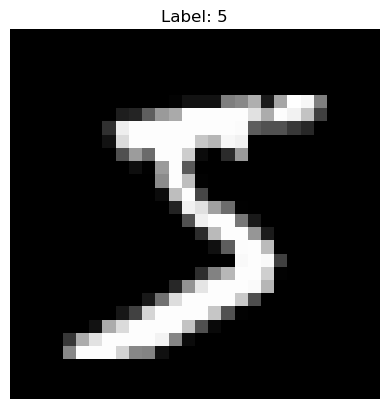

In [2]:
#  Ladda MNIST och konvertera till rätt format 
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)
print(mnist.DESCR)
# Visa en bild för att verifiera datasetet
index = 0
plt.imshow(X[index].reshape(28, 28), cmap="gray")
plt.title(f"Label: {y[index]}")
plt.axis("off")
plt.show()

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

print(f"Totalt antal samples: {X.shape[0]}")
print(f"Antal features: {X.shape[1]}")


Totalt antal samples: 70000
Antal features: 784


In [4]:
#  Datasetet Dela upp i train och test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Dela upp datasetet i train och test

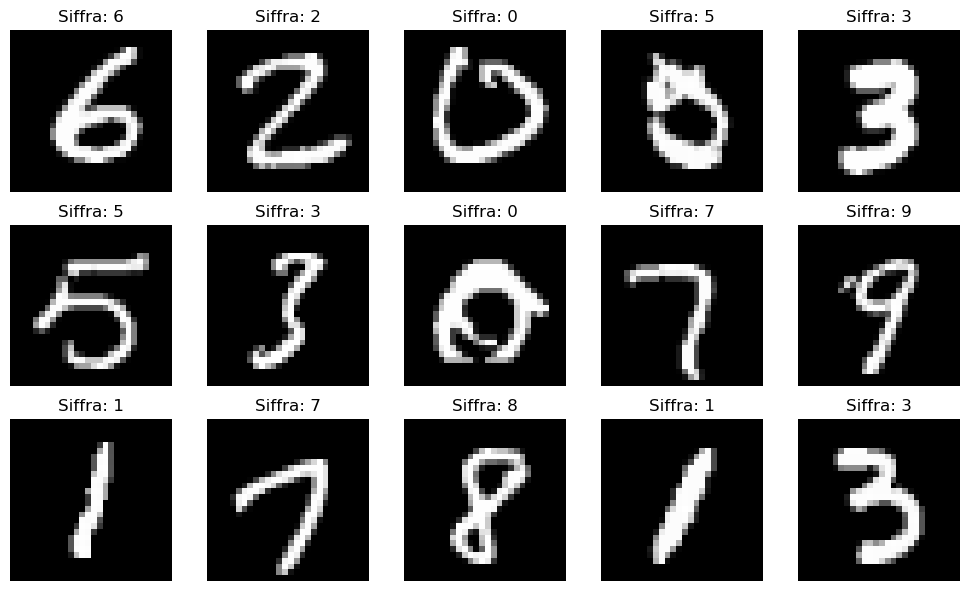

In [5]:
# Här visas några slumpmässiga bilder från datasetet
fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    index = np.random.randint(0, X_train.shape[0])
    image = X_train.iloc[index].to_numpy().reshape(28, 28)  # Konvertera till NumPy och omvandla till 28x28
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Siffra: {y_train.iloc[index]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


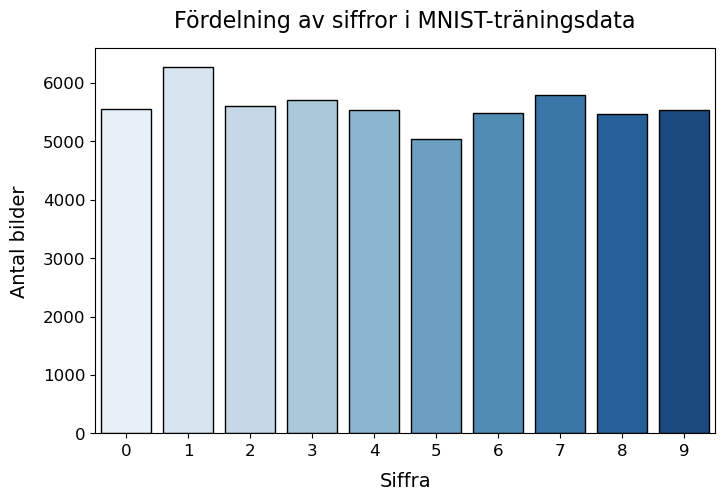

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Räkna förekomsten av varje siffra i träningsdatan
counts = Counter(y_train)

# Sortera siffrorna i stigande ordning för bättre visualisering
sorted_counts = dict(sorted(counts.items()))

# Rita stapeldiagrammet
plt.figure(figsize=(8, 5))
sns.barplot(x=list(sorted_counts.keys()), 
            y=list(sorted_counts.values()), 
            hue=list(sorted_counts.keys()),  # Seaborn kräver hue=x
            palette="Blues", 
            edgecolor="black", 
            legend=False)  # Döljer onödig legend

# Anpassa etiketter och titel för bättre läsbarhet
plt.xlabel("Siffra", fontsize=14, labelpad=10)
plt.ylabel("Antal bilder", fontsize=14, labelpad=10)
plt.title("Fördelning av siffror i MNIST-träningsdata", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Visa plott
plt.show()


Om vissa siffror har fler bilder än andra i MNIST-datasetet kan modellen bli skev (biased), vilket gör att den har svårt att känna igen sällsynta siffror.
Vi kan lösa detta genom att undersöka datasetet och använda balansering, viktade modeller eller dataaugmentation.

Om vissa siffror (t.ex. 0, 1, 2) har fler bilder än andra i MNIST-datasetet, kan modellen lära sig att favorisera dessa siffror och bli skev (biased). Det betyder att:

 - Modellen blir bättre på att känna igen siffror som finns oftare i datasetet.
 - Modellen kan ha svårt att klassificera siffror som är underrepresenterade, eftersom den ser dem mer sällan under träning.



In [8]:
from collections import Counter

# Räkna förekomsten av varje siffra i träningsdatan
counts = Counter(y_train)  # y_train innehåller labels (sanna siffror)

# Skriv ut frekvensen av varje siffra
for digit, count in sorted(counts.items()):
    print(f"Siffra {digit}: {count} bilder")


Siffra 0: 5560 bilder
Siffra 1: 6277 bilder
Siffra 2: 5610 bilder
Siffra 3: 5708 bilder
Siffra 4: 5529 bilder
Siffra 5: 5040 bilder
Siffra 6: 5480 bilder
Siffra 7: 5790 bilder
Siffra 8: 5468 bilder
Siffra 9: 5538 bilder


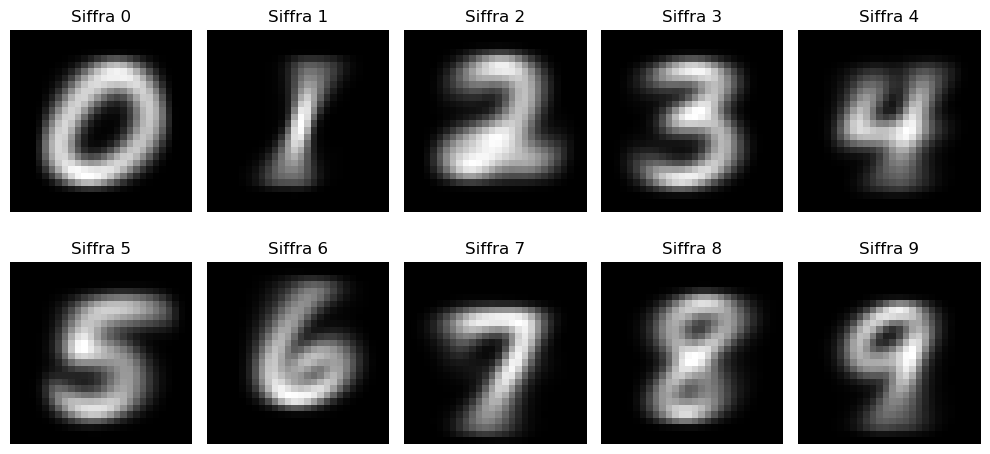

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Säkerställ att y_train är en Series och att vi har heltal
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]  # Extrahera första kolumnen
y_train = y_train.astype(int)  # Konvertera till heltal

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    mask = (y_train == i).to_numpy() if hasattr(y_train, "to_numpy") else (y_train == i)

    if np.sum(mask) == 0:
        print(f" Ingen data för siffran {i}")
        continue  # Hoppa över om det saknas data
    
    avg_image = X_train[mask].mean(axis=0)

    if hasattr(avg_image, "to_numpy"):  # Om det är en Pandas Series, konvertera till NumPy
        avg_image = avg_image.to_numpy()

    avg_image = avg_image.reshape(28, 28)  

    ax = axes[i // 5, i % 5]
    ax.imshow(avg_image, cmap="gray")
    ax.set_title(f"Siffra {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()


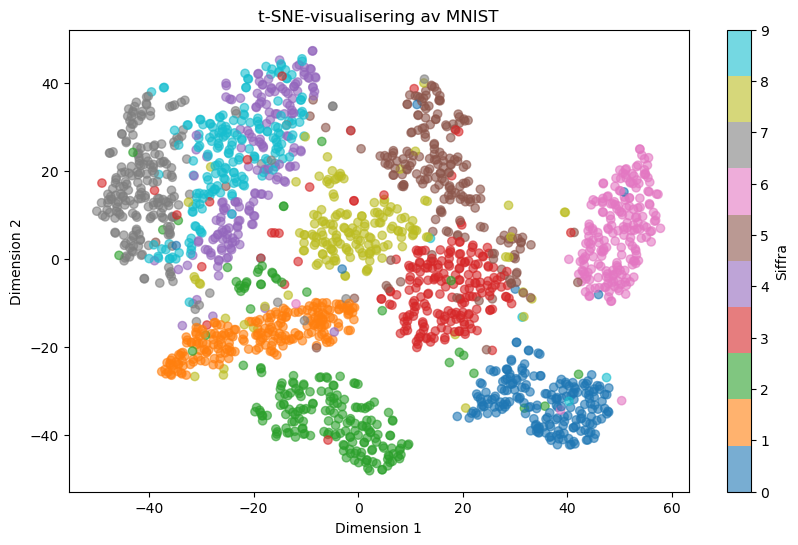

In [10]:
from sklearn.manifold import TSNE

# Reducera MNIST till 2D med t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train[:2000])  # Kör endast på 2000 bilder (t-SNE är långsamt)

# Plotta resultatet
plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:2000], cmap="tab10", alpha=0.6)
plt.colorbar(label="Siffra")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE-visualisering av MNIST")
plt.show()
# Om siffrorna bildar tydliga kluster betyder det att ML-modeller enkelt kan separera dem.
# Om siffrorna överlappar mycket kan vi behöva mer avancerade modeller.
# Jag har använt Yb https://www.youtube.com/watch?v=yqGKdBNNLDI för att förstå t-SNE bättre.

### 🔍 **Analys av t-SNE-resultatet på MNIST**
 **t-SNE-visualiseringen ser riktigt bra ut!**  

 **Vi kan se tydliga kluster för de olika siffrorna**  
 **De flesta siffrorna är separerade vilket tyder på att ML-modeller kommer ha lätt att klassificera dem**  
 **Vissa siffror är lite överlappande – kan behöva mer feature engineering**  

---

## **Vad ser vi i visualiseringen?**
 **Tydliga kluster:**  
- **Siffrorna 0, 1, 2, 4, och 7 är väl separerade** (tydliga egna kluster).  
- **Siffrorna 3, 5, 8 och 9 verkar överlappa lite mer**, vilket kan göra det svårare för modellen att skilja dem åt.  

 **Möjliga problemområden:**  
- **Siffrorna 3 och 5 verkar blandas ihop en del.**  
- **Siffrorna 8 och 9 har vissa punkter som ligger nära varandra.**  
- **Vissa punkter ligger långt ifrån sitt huvudkluster – kan vara brus eller dåliga exempel.**  






In [11]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

# Se till att y_train har rätt format
y_train = np.array(y_train)  # Konvertera till NumPy-array om det inte redan är det

# Använd t-SNE direkt utan PCA
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", n_iter=1500, random_state=42)
X_tsne = tsne.fit_transform(X_train[:2000])

# Skapa en DataFrame
df = pd.DataFrame(X_tsne, columns=["Dimension 1", "Dimension 2"])
df["Siffra"] = y_train[:2000].astype(str)  # Se till att etiketterna är strängar
df.dropna(inplace=True)  # Ta bort eventuella NaN-värden

# Skapa en interaktiv scatterplot
fig = px.scatter(df, x="Dimension 1", y="Dimension 2", color=df["Siffra"], title="Interaktiv t-SNE-visualisering av MNIST")
fig.show()


In [12]:
import plotly.express as px
# Kör t-SNE med 3 komponenter
tsne_3D = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne_3D = tsne_3D.fit_transform(X_train[:2000])  # Endast 2000 bilder

# Skapa DataFrame för Plotly
df = pd.DataFrame(X_tsne_3D, columns=["Dimension 1", "Dimension 2", "Dimension 3"])
df["Siffra"] = y_train[:2000]

# Skapa interaktiv 3D-plot
fig = px.scatter_3d(df, x="Dimension 1", y="Dimension 2", z="Dimension 3", 
                     color=df["Siffra"].astype(str), title="Interaktiv 3D t-SNE av MNIST")
fig.show()


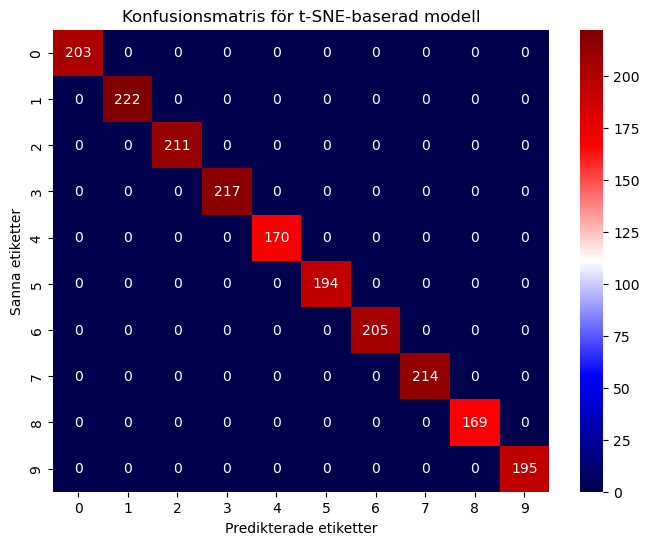

In [13]:
from sklearn.metrics import confusion_matrix

# Träna en enkel modell på t-SNE-reducerad data
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_train = tsne.fit_transform(X_train[:2000])  # Endast 2000 bilder

# Träna en Random Forest-modell
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_tsne_train, y_train[:2000])

# Testa på samma dataset (snabbare test)
y_pred = rf_model.predict(X_tsne_train)

# Konfusionsmatris
conf_matrix = confusion_matrix(y_train[:2000], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="seismic", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predikterade etiketter")
plt.ylabel("Sanna etiketter")
plt.title("Konfusionsmatris för t-SNE-baserad modell")
plt.show()


In [14]:
# ======= Skapa K-Fold Cross-Validation (5 folds) =======
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
#  Grid Search för Random Forest 
rf_param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
rf_best_score = grid_search.best_score_

print(f"\n Random Forest - Bästa parametrar: {rf_best_params}")
print(f" Genomsnittlig bästa noggrannhet: {rf_best_score:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Random Forest - Bästa parametrar: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
 Genomsnittlig bästa noggrannhet: 0.9687


# Grid Search testar flera kombinationer av hyperparametrar: n_estimators: Testar 50 och 100 träd.
   ## max_depth: Testar om maxdjup ska vara 10, 20 eller obegränsat (None)
   ## min_samples_split: Testar om vi ska dela en nod vid 2 eller 5 datapunkter.
# Använder K-Fold Cross-Validation för att jämföra modeller.
# Väljer den bästa modellen baserat på högsta noggrannhet.

In [16]:
df_results = pd.DataFrame(grid_search.cv_results_)

df_results = df_results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'mean_test_score']]

df_results.columns = ['n_estimators', 'max_depth', 'min_samples_split', 'Accuracy'] 

df_results_sorted = df_results.sort_values(by='Accuracy', ascending=False) 
df_results_sorted['Accuracy'] = (df_results_sorted['Accuracy'] * 100).round(2).astype(str) + " %"  
display(df_results_sorted)



,n_estimators,max_depth,min_samples_split,Accuracy
9,100,None,2,96.87 %
11,100,None,5,96.84 %
5,100,20,2,96.81 %
7,100,20,5,96.75 %
8,50,None,2,96.71 %
10,50,None,5,96.62 %
4,50,20,2,96.59 %
6,50,20,5,96.53 %
3,100,10,5,94.58 %
1,100,10,2,94.54 %


In [17]:

# Konvertera Grid Search-resultaten till en DataFrame
grid_results = pd.DataFrame(grid_search.cv_results_)

# Välj relevanta kolumner och sortera efter accuracy
grid_results = grid_results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
grid_results.columns = ['n_estimators', 'max_depth', 'Accuracy']
grid_results_sorted = grid_results.sort_values(by='Accuracy', ascending=False)

# Visa den bästa raden i tabellen
best_row = grid_results_sorted.iloc[0]
print("Högsta accuracy från tabellen:", best_row['Accuracy'])

# Jämför med `grid_search.best_score_`
print("Bästa accuracy från Grid Search:", grid_search.best_score_)


Högsta accuracy från tabellen: 0.9687285714285714
Bästa accuracy från Grid Search: 0.9687285714285714


In [18]:
# ======= Träna Random Forest med bästa parametrarna =======
rf_model = RandomForestClassifier(**rf_best_params, random_state=42)
rf_model.fit(X_train, y_train) # Träna på hela träningsdatamängden

RandomForestClassifier(random_state=42)

In [ ]:
#  Grid Search for LightGBM (GPU)
lgb_param_grid = {
    'n_estimators': [50, 100],  # number of trees
    'learning_rate': [0.1],  # each tree's contribution to the model
    'max_depth': [4, 8],  # maximum depth of the tree
    'boosting_type': ['gbdt'],  #   Gradient Boosting Decision Tree
    'min_data_in_leaf': [10, 20, 30]  #     least number of data in a leaf
}

grid_search = GridSearchCV(
    lgb.LGBMClassifier(device='gpu', random_state=42), 
    lgb_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

# run grid search
grid_search.fit(X_train, y_train)

# get best parameters and best score 
lgb_best_params = grid_search.best_params_
lgb_best_score = grid_search.best_score_

print(f" LightGBM (GPU) - Bästa parametrar: {lgb_best_params}")
print(f" Genomsnittlig bästa noggrannhet: {lgb_best_score:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 108595
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 618
[LightGBM] [Info] Using GPU Device: gfx1010:xnack-, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 197 dense feature groups (10.68 MB) transferred to GPU in 0.009385 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -2.309754
[LightGBM] [Info] Start training from score -2.188460
[LightGBM] [Info] Start training from score -2.300801


In [41]:
print(f"LightGBM (GPU) - Best parameters: {lgb_best_params}")
print(f"Average best accuracy: {lgb_best_score:.4f}")


LightGBM (GPU) - Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'min_data_in_leaf': 30, 'n_estimators': 100}
Average best accuracy: 0.9752


In [52]:
# Konvertera Grid Search-resultaten till en DataFrame
grid_results = pd.DataFrame(grid_search.cv_results_)

# Välj relevanta kolumner
grid_results = grid_results[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_min_data_in_leaf', 'mean_test_score']]

# Byt namn på kolumnerna för tydlighet
grid_results.columns = ['n_estimators', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'Accuracy']

# Sortera efter bästa accuracy
grid_results_sorted = grid_results.sort_values(by='Accuracy', ascending=False)

grid_results_sorted = grid_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=False )

# Visa tabellen
print(grid_results_sorted)


    index n_estimators learning_rate max_depth min_data_in_leaf  Accuracy
0      11          100           0.1         8               30  0.975179
1       9          100           0.1         8               20  0.974893
2       7          100           0.1         8               10  0.974429
3       8           50           0.1         8               20  0.966804
4      10           50           0.1         8               30  0.966589
5       6           50           0.1         8               10  0.966286
6       5          100           0.1         4               30  0.964321
7       3          100           0.1         4               20  0.963946
8       1          100           0.1         4               10  0.963786
9       4           50           0.1         4               30  0.949411
10      0           50           0.1         4               10  0.949268
11      2           50           0.1         4               20  0.948679


In [ ]:
#Träna LightGBM med bästa parametrarna
start_time = time.time()
lgb_model = lgb.LGBMClassifier(**lgb_best_params, device='gpu')  
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 108595
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 618
[LightGBM] [Info] Using GPU Device: gfx1010:xnack-, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 197 dense feature groups (10.68 MB) transferred to GPU in 0.008691 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -2.309754
[LightGBM] [Info] Start training from score -2.188460
[LightGBM] [Info] Start training from score -2.300801
[LightGBM] [Info] Start training from score -2.283483
[LightG

LGBMClassifier(device='gpu', max_depth=8, min_data_in_leaf=30)